# model

In [3]:
import pandas as pd
import cv2
import numpy as np

 
dataset_path = 'C:/python/project/fer2013/fer2013.csv'
image_size=(48,48)
 
def load_fer2013():
    data = pd.read_csv(dataset_path)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).as_matrix()
    return faces, emotions
 
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x
 
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)


c:\users\nandi\anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [2]:
from sklearn.model_selection import train_test_split

In [4]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np
 
# parameters
batch_size = 64
num_epochs = 20
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50
base_path = 'C:/python/project/fer2013'
l2_regularization=0.01
 
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
 
# model parameters
regularization = l2(l2_regularization)
 
# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
 
# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]
 
model.fit_generator(data_generator.flow(xtrain, ytrain,batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,                       
                    validation_data=(xtest,ytest))
model.save('my_model.h5') 

Using TensorFlow backend.
c:\users\nandi\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\nandi\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\nandi\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\nandi\anaconda2\envs\te

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 46, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 46, 46, 8)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Epoch 1/20
449/448 [==============================] - 1107s 2s/step - loss: 1.8069 - acc: 0.3134 - val_loss: 2.0394 - val_acc: 0.3618

Epoch 00001: val_loss improved from inf to 2.03941, saving model to C:/python/project/fer2013_mini_XCEPTION.01-0.36.hdf5
Epoch 2/20
449/448 [==============================] - 1402s 3s/step - loss: 1.5643 - acc: 0.4154 - val_loss: 1.6177 - val_acc: 0.4302

Epoch 00002: val_loss improved from 2.03941 to 1.61775, saving model to C:/python/project/fer2013_mini_XCEPTION.02-0.43.hdf5
Epoch 3/20
449/448 [==============================] - 1069s 2s/step - loss: 1.4432 - acc: 0.4588 - val_loss: 1.4322 - val_acc: 0.4717

Epoch 00003: val_loss improved from 1.61775 to 1.43218, saving model to C:/python/project/fer2013_mini_XCEPTION.03-0.47.hdf5
Epoch 4/20
449/448 [==============================] - 1335s 3s/step - loss: 1.3692 - acc: 0.4906 - val_loss: 1.3842 - val_acc: 0.4915

Epoch 00004: val_loss improved from 1.43218 to 1.38420, saving model to C:/python/project

In [1]:
from keras.models import load_model
model = load_model('my_model.h5')

Using TensorFlow backend.
c:\users\nandi\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\nandi\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\nandi\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\nandi\anaconda2\envs\te

# VIDEO INPUT

In [44]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

In [45]:
count = 0
videoFile = "C:\\Users\\nandi\\Desktop\\videos\\Actor_23\\01-01-07-02-01-01-23.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [1]:
%%HTML
<div align="middle">
<video width="60%" controls>
      <source src="01-01-07-02-01-01-23.mp4" type="video/mp4">
</video></div>

# KEYFRAME

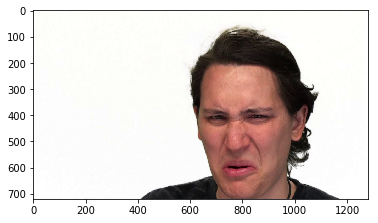

In [46]:
img = plt.imread('frame3.jpg')   # reading image using its name
plt.imshow(img)

# Black and White and Haar Cascade

In [47]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil


def greyscale():
    #img_files=glob(m)
    #print(len(img_files))
   
 
   
        img_name = "frame3.jpg"
        face_img=cv2.imread(img_name,0)
        #grey_img=cv2.cvtColor(face_img,cv2.COLOR_BGR2GRAY)
        face_cascade=cv2.CascadeClassifier("C:\\Users\\nandi\\haarcascade_frontalface_default.xml")
        face_detect=face_cascade.detectMultiScale(face_img, scaleFactor=1.1, minNeighbors=20)
        for(x,y,w,h) in face_detect:
            cv2.rectangle(face_img,(x,y),(x+w,y+h),(0,0,255),2)
            sub_face = face_img[y:y+h, x:x+w]
            cv2.imwrite("C:/Users/nandi/dataset/r/"+img_name, sub_face)
        print("done_final")
    #plt.figure(figsize=(20,10))
    #plt.imshow(cv2.cvtColor(face_img,cv2.COLOR_BGR2RGB))
# x=("C:/Users/nandi/ravdess_train/angry")
      
z=greyscale()


done_final


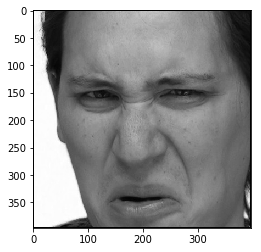

In [48]:
img = plt.imread('C:/Users/nandi/dataset/r/frame3.jpg')   # reading image using its name
plt.imshow(img)

# 48*48 pixel

In [52]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil
from PIL import Image


import os

#for file in glob.glob("C:/Users/nandi/dataset/angry/*.jpg"):
file="C:\\Users\\nandi\\dataset\\r\\frame3.jpg"
v1=os.path.basename(file)
vid_name = os.path.splitext(v1)[0]
im = Image.open("C:\\Users\\nandi\\dataset\\r\\frame3.jpg")
size=(48,48)
out = im.resize(size)
out.save('C:\\Users\\nandi\\dataset\\a\\frame3.jpg')



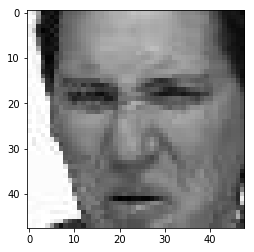

In [53]:
img = plt.imread('C:\\Users\\nandi\\dataset\\a\\frame3.jpg')   # reading image using its name
plt.imshow(img)


# Testing

# DISGUST

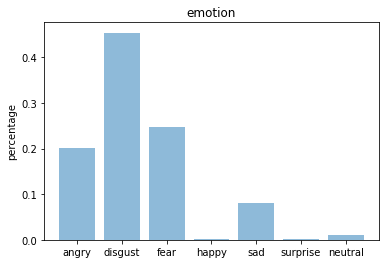

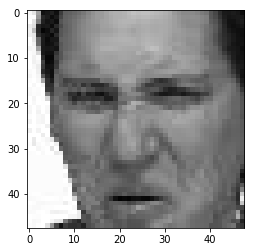

In [54]:

def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = "C:\\Users\\nandi\\dataset\\a\\frame3.jpg"
true_image = image.load_img(file)
img = image.load_img(file, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

# TESTING 2 NEUTRAL

In [29]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

In [34]:
count = 0
videoFile = "C:\\Users\\nandi\\Desktop\\videos\\Video_Speech_Actor_15\\Actor_15\\01-01-01-01-02-01-15.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="framee%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [2]:
%%HTML
<div align="middle">
<video width="60%" controls>
      <source src="01-01-01-01-02-01-15.mp4" type="video/mp4">
</video></div>

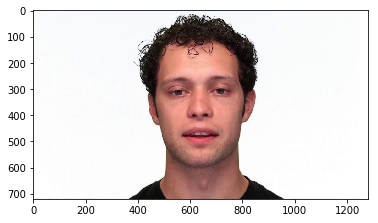

In [35]:
img = plt.imread('framee2.jpg')   # reading image using its name
plt.imshow(img)

In [36]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil


def greyscale():
    #img_files=glob(m)
    #print(len(img_files))
   
 
   
        img_name = "framee2.jpg"
        face_img=cv2.imread(img_name,0)
        #grey_img=cv2.cvtColor(face_img,cv2.COLOR_BGR2GRAY)
        face_cascade=cv2.CascadeClassifier("C:\\Users\\nandi\\haarcascade_frontalface_default.xml")
        face_detect=face_cascade.detectMultiScale(face_img, scaleFactor=1.1, minNeighbors=20)
        for(x,y,w,h) in face_detect:
            cv2.rectangle(face_img,(x,y),(x+w,y+h),(0,0,255),2)
            sub_face = face_img[y:y+h, x:x+w]
            cv2.imwrite("C:/Users/nandi/dataset/r/"+img_name, sub_face)
        print("done_final")
    #plt.figure(figsize=(20,10))
    #plt.imshow(cv2.cvtColor(face_img,cv2.COLOR_BGR2RGB))
# x=("C:/Users/nandi/ravdess_train/angry")
     
z=greyscale()


done_final


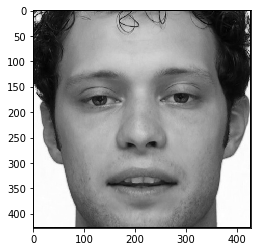

In [37]:
img = plt.imread('C:/Users/nandi/dataset/r/framee2.jpg')   # reading image using its name
plt.imshow(img)

In [55]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil
from PIL import Image


import os

#for file in glob.glob("C:/Users/nandi/dataset/angry/*.jpg"):
file="C:\\Users\\nandi\\dataset\\r\\framee2.jpg"
v1=os.path.basename(file)
vid_name = os.path.splitext(v1)[0]
im = Image.open("C:\\Users\\nandi\\dataset\\r\\framee2.jpg")
size=(48,48)
out = im.resize(size)
out.save('C:\\Users\\nandi\\dataset\\a\\framee2.jpg')




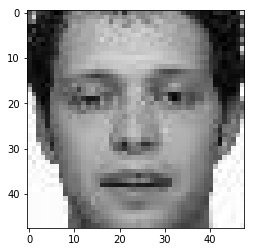

In [56]:
img = plt.imread('C:\\Users\\nandi\\dataset\\a\\framee2.jpg')   # reading image using its name
plt.imshow(img)

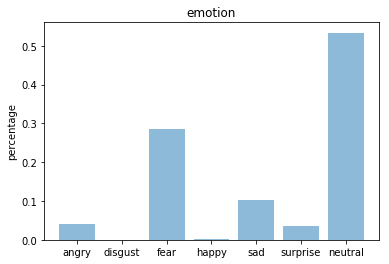

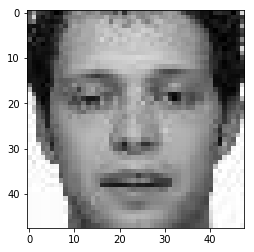

In [57]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = "C:\\Users\\nandi\\dataset\\a\\framee2.jpg"
true_image = image.load_img(file)
img = image.load_img(file, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

# TEST 3 FEAR

In [67]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

In [68]:
count = 0
videoFile = "C:\\Users\\nandi\\Desktop\\videos\\Actor_06\\01-01-06-02-01-02-06.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frameee%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [1]:
%%HTML
<div align="middle">
<video width="60%" controls>
      <source src="01-01-06-02-01-02-06.mp4" type="video/mp4">
</video></div>

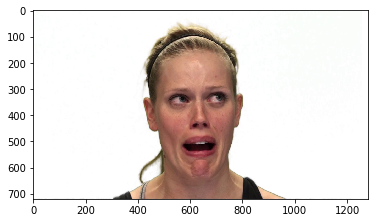

In [70]:
img = plt.imread('frameee2.jpg')   # reading image using its name
plt.imshow(img)

In [71]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil


def greyscale():
    #img_files=glob(m)
    #print(len(img_files))
   
 
   
        img_name = "frameee2.jpg"
        face_img=cv2.imread(img_name,0)
        #grey_img=cv2.cvtColor(face_img,cv2.COLOR_BGR2GRAY)
        face_cascade=cv2.CascadeClassifier("C:\\Users\\nandi\\haarcascade_frontalface_default.xml")
        face_detect=face_cascade.detectMultiScale(face_img, scaleFactor=1.1, minNeighbors=20)
        for(x,y,w,h) in face_detect:
            cv2.rectangle(face_img,(x,y),(x+w,y+h),(0,0,255),2)
            sub_face = face_img[y:y+h, x:x+w]
            cv2.imwrite("C:/Users/nandi/dataset/r/"+img_name, sub_face)
        print("done_final")
    #plt.figure(figsize=(20,10))
    #plt.imshow(cv2.cvtColor(face_img,cv2.COLOR_BGR2RGB))
# x=("C:/Users/nandi/ravdess_train/angry")
     
z=greyscale()


done_final


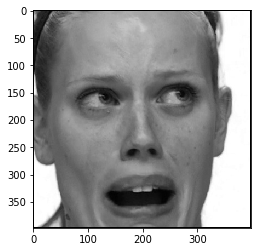

In [72]:
img = plt.imread('C:/Users/nandi/dataset/r/frameee2.jpg')   # reading image using its name
plt.imshow(img)

In [73]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil
from PIL import Image


import os

#for file in glob.glob("C:/Users/nandi/dataset/angry/*.jpg"):
file="C:\\Users\\nandi\\dataset\\r\\framee2.jpg"
v1=os.path.basename(file)
vid_name = os.path.splitext(v1)[0]
im = Image.open("C:\\Users\\nandi\\dataset\\r\\frameee2.jpg")
size=(48,48)
out = im.resize(size)
out.save('C:\\Users\\nandi\\dataset\\a\\frameee2.jpg')




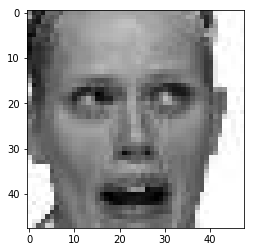

In [74]:
img = plt.imread('C:\\Users\\nandi\\dataset\\a\\frameee2.jpg')   # reading image using its name
plt.imshow(img)

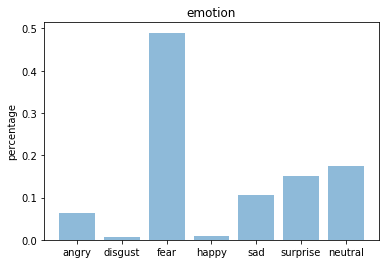

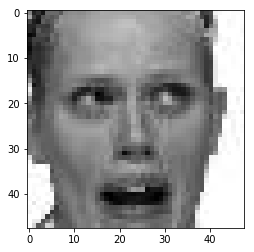

In [75]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = "C:\\Users\\nandi\\dataset\\a\\frameee2.jpg"
true_image = image.load_img(file)
img = image.load_img(file, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

# TEST 4 HAPPY

In [76]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

In [77]:
count = 0
videoFile = "C:\\Users\\nandi\\Desktop\\videos\\Actor_07\\01-01-03-01-01-02-07.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="fra%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [87]:
%%HTML
<div align="middle">
<video width="60%" controls>
      <source src="01-01-03-01-01-02-07.mp4" type="video/mp4">
</video></div>

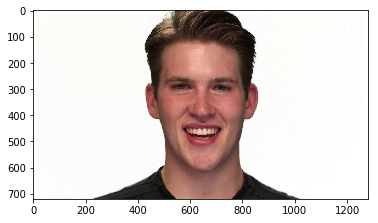

In [78]:
img = plt.imread('fra1.jpg')   # reading image using its name
plt.imshow(img)

In [79]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil


def greyscale():
    #img_files=glob(m)
    #print(len(img_files))
   
 
   
        img_name = "fra1.jpg"
        face_img=cv2.imread(img_name,0)
        #grey_img=cv2.cvtColor(face_img,cv2.COLOR_BGR2GRAY)
        face_cascade=cv2.CascadeClassifier("C:\\Users\\nandi\\haarcascade_frontalface_default.xml")
        face_detect=face_cascade.detectMultiScale(face_img, scaleFactor=1.1, minNeighbors=20)
        for(x,y,w,h) in face_detect:
            cv2.rectangle(face_img,(x,y),(x+w,y+h),(0,0,255),2)
            sub_face = face_img[y:y+h, x:x+w]
            cv2.imwrite("C:/Users/nandi/dataset/r/"+img_name, sub_face)
        print("done_final")
    #plt.figure(figsize=(20,10))
    #plt.imshow(cv2.cvtColor(face_img,cv2.COLOR_BGR2RGB))
# x=("C:/Users/nandi/ravdess_train/angry")
     
z=greyscale()


done_final


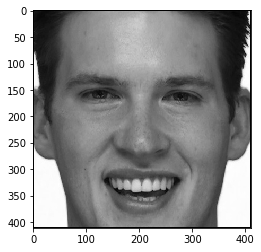

In [80]:
img = plt.imread('C:/Users/nandi/dataset/r/fra1.jpg')   # reading image using its name
plt.imshow(img)

In [84]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil
from PIL import Image


import os

#for file in glob.glob("C:/Users/nandi/dataset/angry/*.jpg"):
file="C:\\Users\\nandi\\dataset\\r\\fra1.jpg"
v1=os.path.basename(file)
vid_name = os.path.splitext(v1)[0]
im = Image.open("C:\\Users\\nandi\\dataset\\r\\fra1.jpg")
size=(48,48)
out = im.resize(size)
out.save('C:\\Users\\nandi\\dataset\\a\\fra1.jpg')




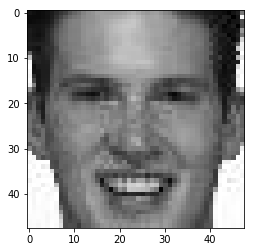

In [85]:
img = plt.imread('C:\\Users\\nandi\\dataset\\a\\fra1.jpg')   # reading image using its name
plt.imshow(img)

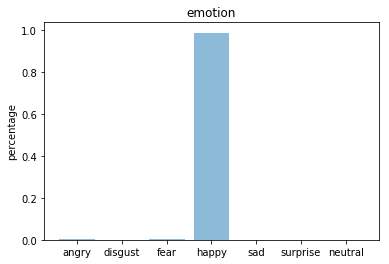

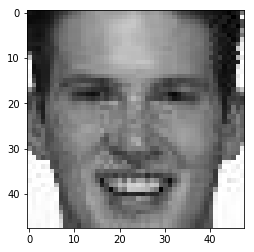

In [86]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = "C:\\Users\\nandi\\dataset\\a\\fra1.jpg"
true_image = image.load_img(file)
img = image.load_img(file, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

In [43]:
%%HTML
<div align="middle">
<video width="60%" controls>
      <source src="01-01-01-01-02-01-15.mp4" type="video/mp4">
</video></div>

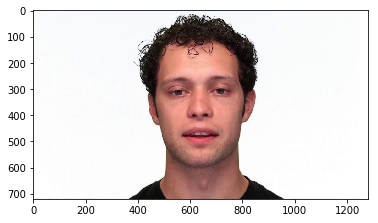

In [35]:
img = plt.imread('framee2.jpg')   # reading image using its name
plt.imshow(img)

In [36]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil


def greyscale():
    #img_files=glob(m)
    #print(len(img_files))
   
 
   
        img_name = "framee2.jpg"
        face_img=cv2.imread(img_name,0)
        #grey_img=cv2.cvtColor(face_img,cv2.COLOR_BGR2GRAY)
        face_cascade=cv2.CascadeClassifier("C:\\Users\\nandi\\haarcascade_frontalface_default.xml")
        face_detect=face_cascade.detectMultiScale(face_img, scaleFactor=1.1, minNeighbors=20)
        for(x,y,w,h) in face_detect:
            cv2.rectangle(face_img,(x,y),(x+w,y+h),(0,0,255),2)
            sub_face = face_img[y:y+h, x:x+w]
            cv2.imwrite("C:/Users/nandi/dataset/r/"+img_name, sub_face)
        print("done_final")
    #plt.figure(figsize=(20,10))
    #plt.imshow(cv2.cvtColor(face_img,cv2.COLOR_BGR2RGB))
# x=("C:/Users/nandi/ravdess_train/angry")
     
z=greyscale()


done_final


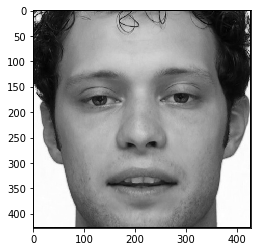

In [37]:
img = plt.imread('C:/Users/nandi/dataset/r/framee2.jpg')   # reading image using its name
plt.imshow(img)

In [40]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil
from PIL import Image


import os

#for file in glob.glob("C:/Users/nandi/dataset/angry/*.jpg"):
file="C:\\Users\\nandi\\dataset\\r\\fr3.jpg"
v1=os.path.basename(file)
vid_name = os.path.splitext(v1)[0]
im = Image.open("C:\\Users\\nandi\\dataset\\r\\fr3.jpg")
size=(48,48)
out = im.resize(size)
out.save('C:\\Users\\nandi\\dataset\\a\\framee2.jpg')




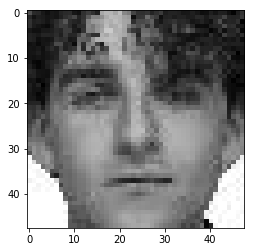

In [41]:
img = plt.imread('C:\\Users\\nandi\\dataset\\a\\framee2.jpg')   # reading image using its name
plt.imshow(img)

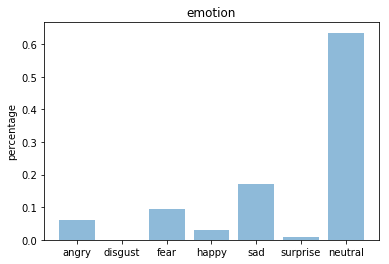

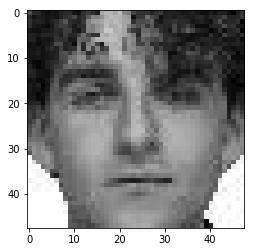

In [42]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = "C:\\Users\\nandi\\dataset\\a\\framee2.jpg"
true_image = image.load_img(file)
img = image.load_img(file, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

In [ ]:
%%HTML
<div align="middle">
<video width="60%" controls>
      <source src="01-01-01-01-02-01-15.mp4" type="video/mp4">
</video></div>

In [ ]:
img = plt.imread('framee2.jpg')   # reading image using its name
plt.imshow(img)

In [ ]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil


def greyscale():
    #img_files=glob(m)
    #print(len(img_files))
   
 
   
        img_name = "framee2.jpg"
        face_img=cv2.imread(img_name,0)
        #grey_img=cv2.cvtColor(face_img,cv2.COLOR_BGR2GRAY)
        face_cascade=cv2.CascadeClassifier("C:\\Users\\nandi\\haarcascade_frontalface_default.xml")
        face_detect=face_cascade.detectMultiScale(face_img, scaleFactor=1.1, minNeighbors=20)
        for(x,y,w,h) in face_detect:
            cv2.rectangle(face_img,(x,y),(x+w,y+h),(0,0,255),2)
            sub_face = face_img[y:y+h, x:x+w]
            cv2.imwrite("C:/Users/nandi/dataset/r/"+img_name, sub_face)
        print("done_final")
    #plt.figure(figsize=(20,10))
    #plt.imshow(cv2.cvtColor(face_img,cv2.COLOR_BGR2RGB))
# x=("C:/Users/nandi/ravdess_train/angry")
     
z=greyscale()



In [ ]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil
from PIL import Image


import os

#for file in glob.glob("C:/Users/nandi/dataset/angry/*.jpg"):
file="C:\\Users\\nandi\\dataset\\r\\fr3.jpg"
v1=os.path.basename(file)
vid_name = os.path.splitext(v1)[0]
im = Image.open("C:\\Users\\nandi\\dataset\\r\\fr3.jpg")
size=(48,48)
out = im.resize(size)
out.save('C:\\Users\\nandi\\dataset\\a\\framee2.jpg')


In [ ]:
img = plt.imread('C:\\Users\\nandi\\dataset\\a\\framee2.jpg')   # reading image using its name
plt.imshow(img)

In [ ]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = "C:\\Users\\nandi\\dataset\\a\\framee2.jpg"
true_image = image.load_img(file)
img = image.load_img(file, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

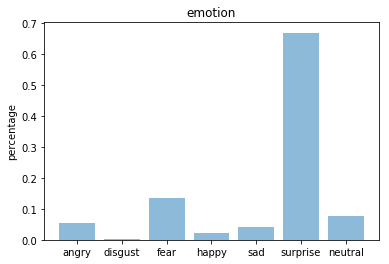

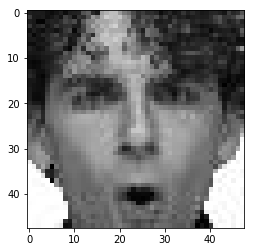

In [42]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = "C:\\Users\\nandi\\dataset\\dd\\suprise\\surprise01-01-08-02-02-01-17_f2.jpg"
true_image = image.load_img(file)
img = image.load_img(file, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

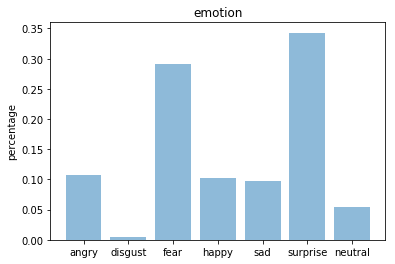

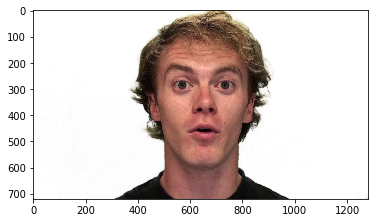

In [52]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = "frame2.jpg"
true_image = image.load_img(file)
img = image.load_img(file, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

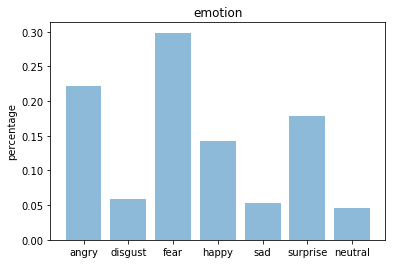

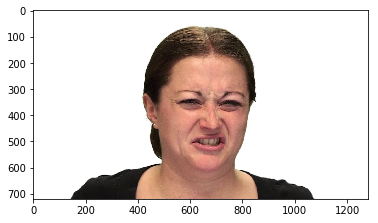

In [12]:
true_image = image.load_img(file)
img = image.load_img(file, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

done_final


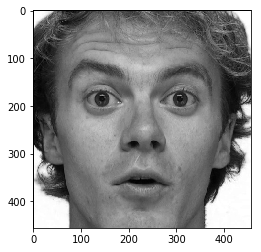

In [64]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil


def greyscale():
    #img_files=glob(m)
    #print(len(img_files))
   
 
   
        img_name = "frame2.jpg"
        face_img=cv2.imread(img_name,0)
        #grey_img=cv2.cvtColor(face_img,cv2.COLOR_BGR2GRAY)
        face_cascade=cv2.CascadeClassifier("C:\\Users\\nandi\\haarcascade_frontalface_default.xml")
        face_detect=face_cascade.detectMultiScale(face_img, scaleFactor=1.1, minNeighbors=20)
        for(x,y,w,h) in face_detect:
            cv2.rectangle(face_img,(x,y),(x+w,y+h),(0,0,255),2)
            sub_face = face_img[y:y+h, x:x+w]
            cv2.imwrite("C:/Users/nandi/dataset/r/"+img_name, sub_face)
        print("done_final")
    #plt.figure(figsize=(20,10))
    #plt.imshow(cv2.cvtColor(face_img,cv2.COLOR_BGR2RGB))
# x=("C:/Users/nandi/ravdess_train/angry")
        img = plt.imread('C:/Users/nandi/dataset/r/frame2.jpg')   # reading image using its name
        plt.imshow(img)
z=greyscale()

In [67]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize
import glob

import os
import shutil
from PIL import Image


import os

#for file in glob.glob("C:/Users/nandi/dataset/angry/*.jpg"):
v1=os.path.basename(file)
vid_name = os.path.splitext(v1)[0]
im = Image.open("C:\\Users\\nandi\\dataset\\r\\frame2.jpg")
size=(48,48)
out = im.resize(size)
out.save('C:\\Users\\nandi\\dataset\\a\\frame2.jpg')

In [ ]:
from keras.models import load_model
model = load_model('my_model.h5')

Using TensorFlow backend.


In [1]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


file = "C:\\Users\\nandi\\desktop\\dataset_final\\fear\\fear01-01-06-02-01-02-03_f0.jpg"
true_image = image.load_img(file)
img = image.load_img(file, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(true_image)
plt.show()

Using TensorFlow backend.
c:\users\nandi\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\nandi\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\nandi\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\nandi\anaconda2\envs\te

KeyboardInterrupt: 

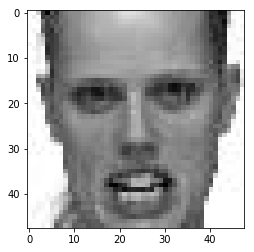

In [3]:
model = load_model('xception_150.h5')

In [ ]:
import cv2
import numpy as np
import os
import keras
from keras.models import load_model


dicts = ['empty', 'neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise', 'neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']

# To capture video from a webcam
cap = cv2.VideoCapture(0)

if not (cap.isOpened()):
    print('Could not open video device')

# Load the cascade
face_cascade = cv2.CascadeClassifier('C:\\Users\\nandi\\haarcascade_frontalface_default.xml') 
font = cv2.FONT_HERSHEY_SIMPLEX
# To use a video file as input 
# cap = cv2.VideoCapture('filename.mp4')
model = keras.models.load_model('my_model.h5')
counts = {}
while True:
    # Read the frame
    _, frame = cap.read()
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Detect the faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    # Draw the rectangle around each face
    for (x, y, w, h) in faces:
        fc = frame[y:y+w, x:x+w]
        # crop over resize
        fin = cv2.resize(fc, (224, 224))
        roi = cv2.resize(fc, (224, 224))
        roi = np.expand_dims(roi, axis=0)
        pred = model.predict(roi)
        rounded_prediction = np.argmax(pred, axis=1)
        emotion = dicts[rounded_prediction[0]]
        cv2.putText(frame, str(emotion), (x, y), font, 1, (255, 255, 0), 2)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    if cv2.waitKey(1) == 27:
        break
    cv2.imshow('Filter', frame)
    # Stop if escape key is pressed
    k = cv2.waitKey(30) & 0xff
    if k==27:
        break
# Release the VideoCapture object
cap.release()

In [15]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow 
from tensorflow import keras
from keras import models


#Importing the model
trained_model = models.load_model('my_model.h5', compile=False)
trained_model.summary()
# prevents openCL usage and unnecessary logging messages
cv2.ocl.setUseOpenCL(False)
# dictionary which assigns each label an emotion (alphabetical order)
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: 'Neutral'}
detector = ''
# start the webcam feed
cap = cv2.VideoCapture(0)
black = np.zeros((96,96))

while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
	# detect faces in the image
    results = detector.detect_faces(frame)
	# extract the bounding box from the first face
    if len(results) == 1: #len(results)==1 if there is a face detected. len ==0 if no face is detected
        try:
            x1, y1, width, height = results[0]['box']
            x2, y2 = x1 + width, y1 + height
        	# extract the face
            face = frame[y1:y2, x1:x2]
            #Draw a rectangle around the face
            cv2.rectangle(frame, (x1, y1), (x1+width, y1+height), (255, 0, 0), 2)
            # resize pixels to the model size
            cropped_img = cv2.resize(face, (96,96)) 
            cropped_img_expanded = np.expand_dims(cropped_img, axis=0)
            cropped_img_float = cropped_img_expanded.astype(float)
            prediction = trained_model.predict(cropped_img_float)
            print(prediction)
            maxindex = int(np.argmax(prediction))
            cv2.putText(frame, emotion_dict[maxindex], (x1+20, y1-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        except:
            pass
    cv2.imshow('Video',frame)
    try:
        cv2.imshow("frame", cropped_img)
    except:
        cv2.imshow("frame", black)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 46, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 46, 46, 8)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

AttributeError: 'str' object has no attribute 'detect_faces'

In [12]:
! pip3 install mtcnn

You should consider upgrading via the 'c:\users\nandi\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
! pip3 install mtcnn

You should consider upgrading via the 'c:\users\nandi\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.
